Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [302]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import BatchNormalization 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomCrop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image_dataset_from_directory
from glob import glob
import Augmentor
from sklearn.metrics import confusion_matrix, accuracy_score

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [234]:
data_dir_train = pathlib.Path("C:\Melanoma Detection Assignment\CNN_assignment\images\Train")
data_dir_test = pathlib.Path('C:\Melanoma Detection Assignment\CNN_assignment\images\Test')

In [235]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create Train & Validation datasets from image folders

In [236]:
batch_size = 32
img_height = 180
img_width = 180

In [237]:
train_ds, val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


test_ds = image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.
Found 118 files belonging to 9 classes.


In [238]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names

print(class_names)

num_classes = len(class_names)

print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [239]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the Base model - Include Rescaling

In [240]:

model = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])


#### Compile the Base model

In [241]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [242]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

#### Train the model

In [243]:
epochs = 20
trainHistory = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 17s 77ms/step - loss: 1.6706 - accuracy: 0.3548 - val_loss: 1.5180 - val_accuracy: 0.4209
Epoch 2/20
169/169 [==============================] - 13s 80ms/step - loss: 1.3567 - accuracy: 0.4879 - val_loss: 1.2293 - val_accuracy: 0.5486
Epoch 3/20
169/169 [==============================] - 14s 85ms/step - loss: 1.1817 - accuracy: 0.5684 - val_loss: 1.1803 - val_accuracy: 0.5620
Epoch 4/20
169/169 [==============================] - 14s 85ms/step - loss: 0.9892 - accuracy: 0.6343 - val_loss: 1.0574 - val_accuracy: 0.6177
Epoch 5/20
169/169 [==============================] - 14s 85ms/step - loss: 0.8353 - accuracy: 0.6986 - val_loss: 1.0344 - val_accuracy: 0.6511
Epoch 6/20
169/169 [==============================] - 14s 85ms/step - loss: 0.6547 - accuracy: 0.7676 - val_loss: 1.0744 - val_accuracy: 0.6474
Epoch 7/20
169/169 [==============================] - 14s 84ms/step - loss: 0.5333 - accuracy: 0.8042 - val_loss: 0.9320 - val_accuracy:

#### Visualizing training results

##### Helper function for visualizing results

In [244]:


def VisualizeResults(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


##### Visualize Results

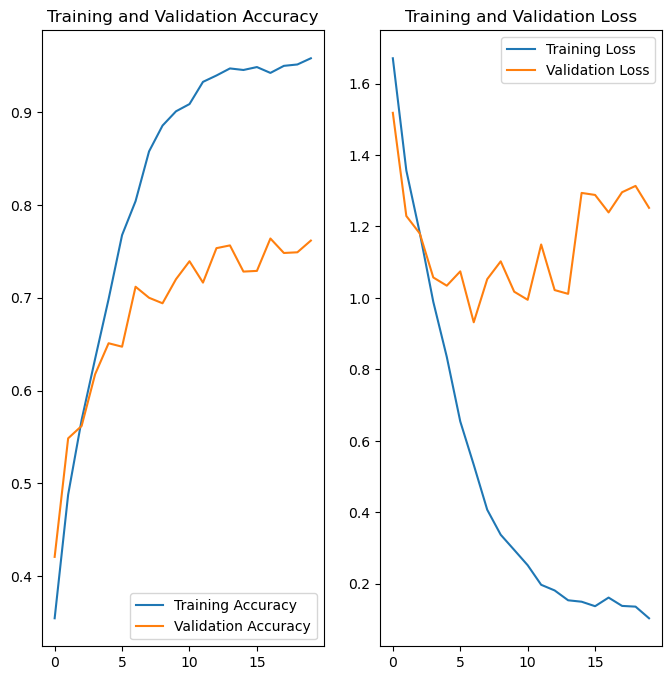

In [245]:
VisualizeResults(trainHistory)

### Handling Class Imbalance

#### Helper function to analyse the image counts for classes

In [246]:
### Helper function to count the files for classes

def CountImagesForClasses(dir_train):
    dirs = [f for f in dir_train.iterdir() if f.is_dir()]
    dicDir = {}

    for dir in dirs:
        currdir = pathlib.Path(os.path.join(data_dir_train, dir))
    
        cnt = len(list(currdir.rglob("*.jpg")))
        dicDir[currdir.name] = cnt
    
    df = pd.DataFrame(dicDir.items(), columns=['Class', 'Number'])
    return df

#### Image Analysis before Augmentation

                        Class  Number
0           actinic keratosis     614
1        basal cell carcinoma     876
2              dermatofibroma     595
3                    melanoma     938
4                       nevus     857
5  pigmented benign keratosis     962
6        seborrheic keratosis     577
7     squamous cell carcinoma     681
8             vascular lesion     639


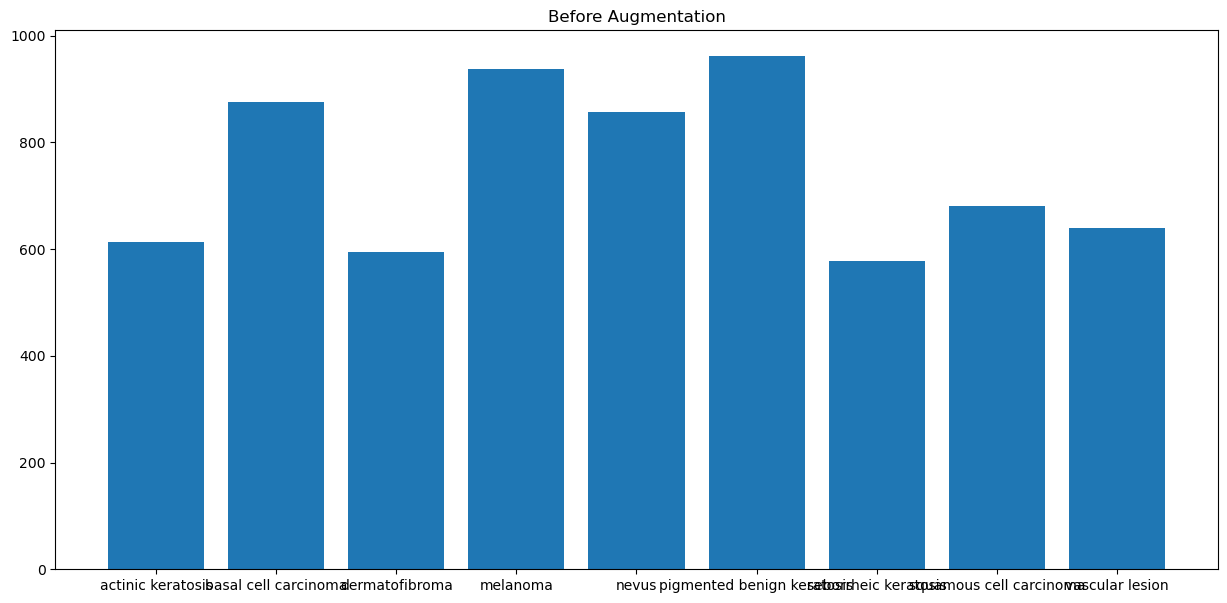

In [247]:
dfClasses = CountImagesForClasses(data_dir_train)

print(dfClasses)

plt.figure(figsize=(15,7))
plt.title("Before Augmentation")
plt.bar(data=dfClasses, x="Class", height="Number")
plt.show()

#### Use Augmentor to rectify the class imbalance


In [248]:
## generate 500 images for each class using Augmentor

for className in class_names:
    p = Augmentor.Pipeline(data_dir_train.joinpath(className))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5C721410>: 100%|██████████| 500/500 [00:02<00:00, 183.15 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5C72DFD0>: 100%|██████████| 500/500 [00:02<00:00, 180.89 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27B5B2DC550>: 100%|██████████| 500/500 [00:02<00:00, 174.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27B5AEA1CD0>: 100%|██████████| 500/500 [00:13<00:00, 37.24 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5C7C4790>: 100%|██████████| 500/500 [00:13<00:00, 36.36 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5B11CB10>: 100%|██████████| 500/500 [00:02<00:00, 180.47 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27B5C817390>: 100%|██████████| 500/500 [00:06<00:00, 77.69 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5C826C10>: 100%|██████████| 500/500 [00:02<00:00, 179.26 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Melanoma Detection Assignment\CNN_assignment\images\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27B5FACFE90>: 100%|██████████| 500/500 [00:02<00:00, 182.28 Samples/s]                  


#### Image Analysis After Augmentation

                        Class  Number
0           actinic keratosis    1114
1        basal cell carcinoma    1376
2              dermatofibroma    1095
3                    melanoma    1438
4                       nevus    1357
5  pigmented benign keratosis    1462
6        seborrheic keratosis    1077
7     squamous cell carcinoma    1181
8             vascular lesion    1139


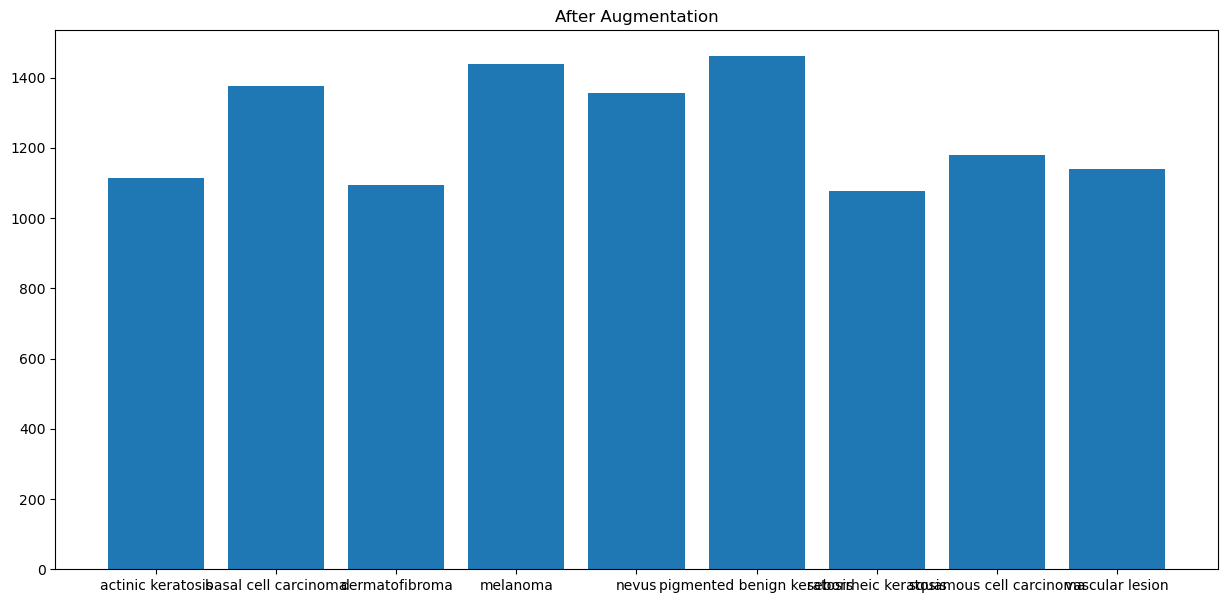

In [249]:
dfClasses = CountImagesForClasses(data_dir_train)

print(dfClasses)

plt.figure(figsize=(15,7))
plt.title("After Augmentation")
plt.bar(data=dfClasses, x="Class", height="Number")
plt.show()

#### Train the model on the data created using Augmentor

In [250]:
batch_size = 32
img_height = 180
img_width = 180

In [251]:

train_ds, val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.
Using 2247 files for validation.


In [252]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])

#### Compile the model 

In [253]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train the model

In [254]:
epochs = 30

trainHistory = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


c:\Users\ncjan\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 [==============================] - 53s 145ms/step - loss: 2.1251 - accuracy: 0.3490 - val_loss: 18.7351 - val_accuracy: 0.1375
Epoch 2/30
281/281 [==============================] - 38s 134ms/step - loss: 1.4156 - accuracy: 0.4532 - val_loss: 2.3859 - val_accuracy: 0.3698
Epoch 3/30
281/281 [==============================] - 38s 134ms/step - loss: 1.2289 - accuracy: 0.5208 - val_loss: 1.7174 - val_accuracy: 0.3627
Epoch 4/30
281/281 [==============================] - 38s 135ms/step - loss: 1.0954 - accuracy: 0.5765 - val_loss: 1.2910 - val_accuracy: 0.4976
Epoch 5/30
281/281 [==============================] - 38s 134ms/step - loss: 0.9483 - accuracy: 0.6469 - val_loss: 1.1453 - val_accuracy: 0.5870
Epoch 6/30
281/281 [==============================] - 38s 134ms/step - loss: 0.7834 - accuracy: 0.7114 - val_loss: 1.5996 - val_accuracy: 0.5109
Epoch 7/30
281/281 [==============================] - 38s 135ms/step - loss: 0.6646 - accuracy: 0.7519 - val_loss: 1.9724 - val_accuracy: 0.

#### Visualize the model results

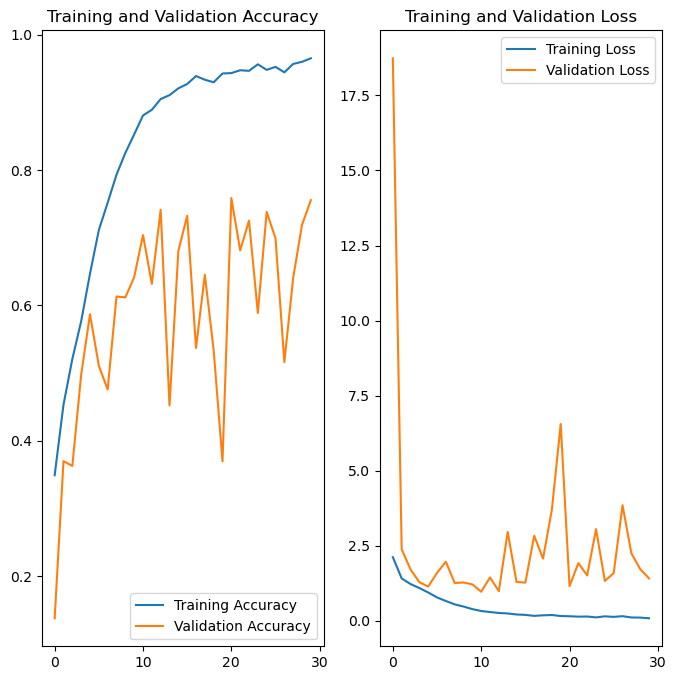

In [255]:
VisualizeResults(trainHistory)

### Model With More Feature Maps

In [256]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')]
)

In [257]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [258]:
epochs = 30

trainHistory = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 172s 600ms/step - loss: 2.3597 - accuracy: 0.2785 - val_loss: 28.7407 - val_accuracy: 0.1108
Epoch 2/30
281/281 [==============================] - 171s 605ms/step - loss: 1.7045 - accuracy: 0.3371 - val_loss: 2.0248 - val_accuracy: 0.3026
Epoch 3/30
281/281 [==============================] - 162s 578ms/step - loss: 1.6089 - accuracy: 0.3778 - val_loss: 1.5393 - val_accuracy: 0.3818
Epoch 4/30
281/281 [==============================] - 165s 586ms/step - loss: 1.5069 - accuracy: 0.4018 - val_loss: 1.5806 - val_accuracy: 0.3609
Epoch 5/30
281/281 [==============================] - 163s 582ms/step - loss: 1.4663 - accuracy: 0.4210 - val_loss: 2.0041 - val_accuracy: 0.2813
Epoch 6/30
281/281 [==============================] - 161s 573ms/step - loss: 1.4007 - accuracy: 0.4414 - val_loss: 1.5359 - val_accuracy: 0.4059
Epoch 7/30
281/281 [==============================] - 162s 577ms/step - loss: 1.3461 - accuracy: 0.4657 - val_loss: 1.5091 

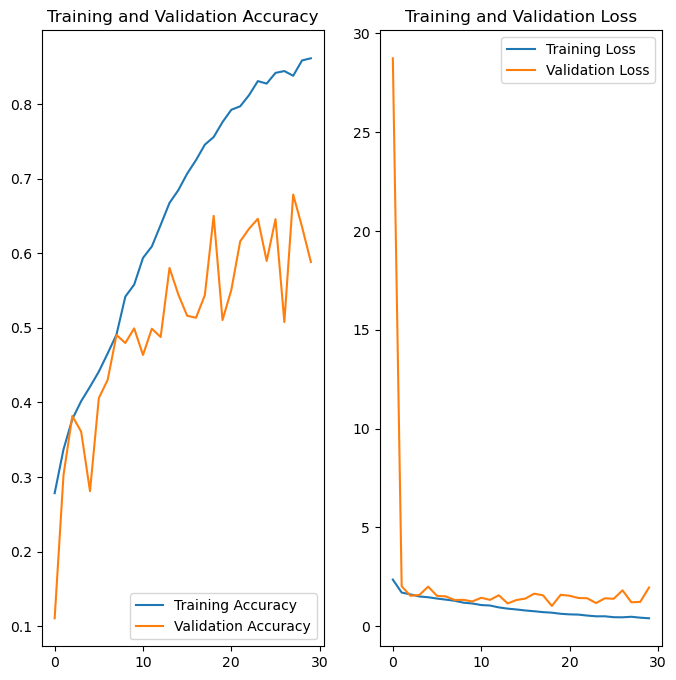

In [259]:
VisualizeResults(trainHistory)

### Run on Test Data

In [276]:
predictions = model.predict(test_ds)

4/4 [==============================] - 1s 193ms/step
(118, 9)
[8.6364132e-08 5.5409449e-01 6.5098808e-04 2.5235179e-06 7.2925623e-06
 6.2313804e-04 8.2730567e-12 4.5749675e-05 4.4457570e-01]


In [297]:
prediction_classes = np.argmax(predictions, axis=1)

prediction_classes

array([1, 5, 7, 4, 0, 1, 8, 4, 0, 4, 1, 1, 0, 5, 1, 1, 5, 4, 4, 5, 3, 1,
       4, 3, 4, 3, 4, 5, 5, 4, 4, 3, 7, 0, 0, 0, 2, 3, 4, 0, 3, 4, 1, 7,
       1, 3, 3, 3, 1, 5, 3, 4, 3, 3, 5, 4, 5, 3, 3, 4, 7, 4, 4, 7, 1, 3,
       4, 7, 5, 4, 4, 3, 3, 8, 1, 1, 7, 4, 4, 1, 1, 1, 2, 5, 7, 4, 7, 5,
       1, 4, 3, 5, 4, 2, 0, 0, 7, 7, 0, 0, 4, 6, 0, 3, 3, 1, 4, 4, 7, 7,
       4, 5, 5, 3, 5, 7, 3, 4], dtype=int64)

In [298]:
test_classes = [item[1] for item in test_ds.as_numpy_iterator()]

test_classes = np.concatenate(test_classes)

test_classes

array([1, 7, 1, 4, 0, 1, 8, 3, 0, 4, 1, 1, 7, 5, 0, 7, 2, 3, 3, 0, 6, 1,
       2, 3, 3, 0, 4, 5, 2, 3, 5, 6, 2, 0, 5, 1, 1, 3, 3, 7, 2, 3, 8, 5,
       2, 6, 5, 7, 0, 5, 4, 4, 3, 3, 5, 7, 7, 4, 0, 3, 0, 4, 7, 1, 2, 2,
       4, 1, 7, 4, 4, 7, 5, 8, 5, 1, 1, 3, 4, 2, 5, 2, 0, 5, 7, 4, 2, 2,
       1, 3, 4, 4, 1, 2, 0, 5, 7, 0, 0, 2, 7, 5, 5, 1, 2, 3, 3, 4, 0, 1,
       4, 5, 7, 7, 2, 7, 0, 0])

In [300]:
cm = confusion_matrix(test_classes, prediction_classes)

print(cm)

[[ 5  2  1  3  1  1  0  3  0]
 [ 1  7  1  1  1  0  0  5  0]
 [ 1  4  1  3  1  4  0  2  0]
 [ 0  1  0  4 11  0  0  0  0]
 [ 0  0  0  3 12  1  0  0  0]
 [ 3  2  0  2  1  6  1  1  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 2  1  0  3  3  4  0  3  0]
 [ 0  1  0  0  0  0  0  0  2]]
